In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns; sns.set_style();
import pytorch_lightning as pl
from model.model_ctc import ModelCTC
from PIL import Image
import pandas as pd
from matplotlib.patches import Rectangle

In [16]:
device = 'cpu'
# model = ModelCTC.load_from_checkpoint('/home/python/Documents/Thesis/vietnamese-htr/runs/ctc_256/checkpoints/epoch=44.ckpt', map_location=device)
model = ModelCTC.load_from_checkpoint('/home/python/Documents/Thesis/vietnamese-htr/runs/ctc_512_2layers/lightning_logs/version_0/checkpoints/epoch=48.ckpt', map_location=device)
model.eval();

In [17]:
image_transform = model.transform.test

In [18]:
path = 'data/VNOnDB/word/test_word/20151209_0144_7398_1_tg_0_1_15.png'
csv = 'data/VNOnDB/word/test_word_new.csv'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


77 96


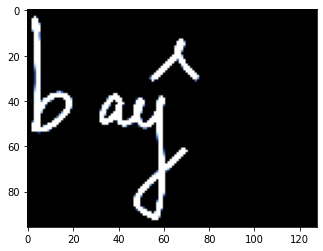

In [19]:
image = Image.open(path).convert('L')
width, height = image.size
print(width, height)
image = image_transform(image)
plt.imshow(image.permute(1,2,0))

In [20]:
df = pd.read_csv(csv, sep='\t', keep_default_na=False)
gt = df.loc[df['id']==path.split('/')[-1], 'label'].values[0]
print(f"Ground truth: {gt}")

Ground truth: bảy


In [21]:
with torch.no_grad():
    outputs = model.decode(image.unsqueeze(0), 1)
    print(outputs)
    for output in outputs.cpu().tolist():
        output = list(map(model.vocab.int2char, output))
        output = model.vocab.process_label_invert(output)
        output = ' '.join(output)
        print(output)

tensor([[ 14, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145,
           1,  45]])
b <blank> <blank> <blank> <blank> <blank> <blank> <blank> <blank> <blank> <blank> <blank> <blank> <blank> ả y


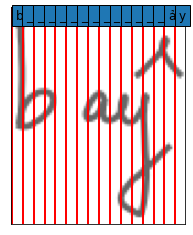

In [22]:
def visualize_ctc(outputs):
    B, T= outputs.shape
    timestep_width = width/T

    for i, sample in enumerate(outputs):
        # sample: [T]
        output = list(map(model.vocab.int2char, sample))
        output = model.vocab.process_label_invert(output)
        
        image = Image.open(path).convert('L').resize((width, height))
        
        fig, axes = plt.subplots(1)
        axes.imshow(image, cmap='gray', alpha=0.6)
        for j, char in enumerate(output):
#             plt.axis('off')
            if char=='<blank>':
                char = '_'
            fig = plt.text(j*timestep_width+timestep_width/3, 5, char, fontsize=12,
                          bbox=dict(fill=True))
            fig = plt.gca().add_patch(
                Rectangle((j*timestep_width,0), timestep_width, height, linewidth=2, edgecolor='r', facecolor='none'))
            axes.get_xaxis().set_visible(False)
            axes.get_yaxis().set_visible(False)
            plt.savefig(f'misc/ctc.png', bbox_inches='tight', pad_inches = 0.1)
        plt.show()
            
visualize_ctc(outputs)

In [23]:
model

ModelCTC(
  (cnn): ResnetFE(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, mome